## TSS alignment midbrain markers

In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
import pickle

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.preprocessing.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [2]:
## Import path to the relevant 10X reference dataset

ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
f_atac = '/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom'
f_agg = '/proj/human_development/emelie_20190912/data/Midbrain.agg.loom'

pybedtools.helpers.set_bedtools_path('/data/bin/bedtools2/bin')

pad = 1000

In [152]:
ds = loompy.connect(f_atac, mode='r')
dsa = loompy.connect(f_agg, mode='r', validate=False)

In [5]:
fa = '/home/camiel/misc/10X232_4.bed'
fb = '/home/camiel/misc/10X232_3.bed'

## Setup BedTool 1
logging.info(f"Setup BedTool 1")
frags = BedTool(fa)
# logging.info(f"Merge with file 2")
## Merge with file2
# frags = a.cat(fb)
logging.info(f"Loaded in total {len(frags)} fragments")

10:42:40 INFO     Setup BedTool 1
10:42:40 INFO     Merge with file 2


223299675

In [7]:
(top_enr,) = dsa['enrichment'].map([np.max], axis=0)
q = 1 - (2000 / dsa.shape[0])
lim = np.quantile(top_enr, q)
logging.info(f"Minimum enrichment: {lim} with {sum(top_enr>lim)} genes")
selected = dsa.ra['Accession', 'Gene'][top_enr>lim,:]

10:55:20 INFO     64.28052619313195 with 2000 genes


In [94]:
sel = np.random.choice(np.arange(dsa.shape[0]), size=2000, replace=False)
Rsel = np.zeros(dsa.shape[0], dtype=int)
Rsel[sel] = 1
Random_genes = dsa.ra['Accession', 'Gene'][Rsel,:]
logging.info(f"Selected 2.000 random background genes")

12:18:50 INFO     Selected 2.000 random background genes


In [106]:
def TSS_enrichment(fragments, selected, pad=2000):
    ## Load TSS sites
    tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
    TSS = []
    logging.info(f"Removing TSS not in selection list")
    for x in tss:
        if x[3] in selected:
            TSS.append(x)
    del tss
    TSS = BedTool(TSS)
    logging.info(f"Create padded bedtool")
    TSS_pad = TSS.slop(b=pad, genome = 'hg38')

    ## Filter our fragments not overlapping TSS_pad
    logging.info(f"filter out fragments not overlapping padded area")
    filt = fragments.intersect(TSS_pad)
    logging.info(f"Remaining fragments: {len(filt)}")

    ## Get middle every fragments (mean min/max)
    logging.info(f"Extracting midpoint for all fragments")
    mids = []
    i = 0
    for x in filt:
        st = round((int(x[1]) + int(x[2]))/2)
        end = st + 1
        mids.append([x[0],st, end])
        i += 1
        if i%2000000 == 0:
            logging.info(f"Processed: {i} frags")
    mids = BedTool(mids)

    ## Distance to closest TSS
    logging.info(f"Calculated distancesing")
    dists = mids.sort().closest(TSS.sort(), D='b')

    ## Calculate distances
    logging.info(f"Calculating distances to nearest TSS")
    d = []
    i = 0
    err = []
    for x in dists:
        try:
            d.append(x[10])
        except:
            err.append(x)
        i += 1
        if i%2000000 == 0:
            logging.info(f"Calculated distance for {i} fragments")

    logging.info(f"Sort and return array of TSS enrichment")
    from collections import Counter
    counts = Counter(d)
    pos = []
    for k in counts:
        pos.append((k,counts[k]))
    pos = np.array(pos, dtype=[('dist', int), ('count', float)])
    pos = np.sort(pos, order='dist')

    return pos

logging.info(f"Start processing enriched genes")
pos = TSS_enrichment(frags, selected, pad=pad)
logging.info(f"Start processing background genes")
pos_bg = TSS_enrichment(frags, Random_genes, pad=pad)

13:11:53 INFO     Removing TSS not in selection list
13:12:04 INFO     Create padded bedtool
13:12:04 INFO     filter out fragments not overlapping padded area
13:14:31 INFO     Remaining fragments: 14076449
13:14:31 INFO     Extracting midpoint for all fragments
13:14:38 INFO     1000000
13:14:44 INFO     2000000
13:14:50 INFO     3000000
13:14:57 INFO     4000000
13:15:03 INFO     5000000
13:15:08 INFO     6000000
13:15:15 INFO     7000000
13:15:20 INFO     8000000
13:15:26 INFO     9000000
13:15:32 INFO     10000000
13:15:38 INFO     11000000
13:15:44 INFO     12000000
13:15:49 INFO     13000000
13:15:56 INFO     14000000
13:16:59 INFO     Calculated distancesing
13:17:56 INFO     Calculating distances to nearest TSS
13:18:05 INFO     1000000
13:18:14 INFO     2000000
13:18:22 INFO     3000000
13:18:31 INFO     4000000
13:18:40 INFO     5000000
13:18:48 INFO     6000000
13:18:57 INFO     7000000
13:19:06 INFO     8000000
13:19:14 INFO     9000000
13:19:23 INFO     10000000
13:19:32 

In [118]:
from numpy.lib.recfunctions import append_fields
pos = append_fields(pos, 'fraq', np.zeros(pos.shape[0]))
pos_bg = append_fields(pos_bg, 'fraq', np.zeros(pos_bg.shape[0]))

pos['fraq'] = pos['count']/max(pos['count'])
pos_bg['fraq'] = pos_bg['count']/max(pos_bg['count'])

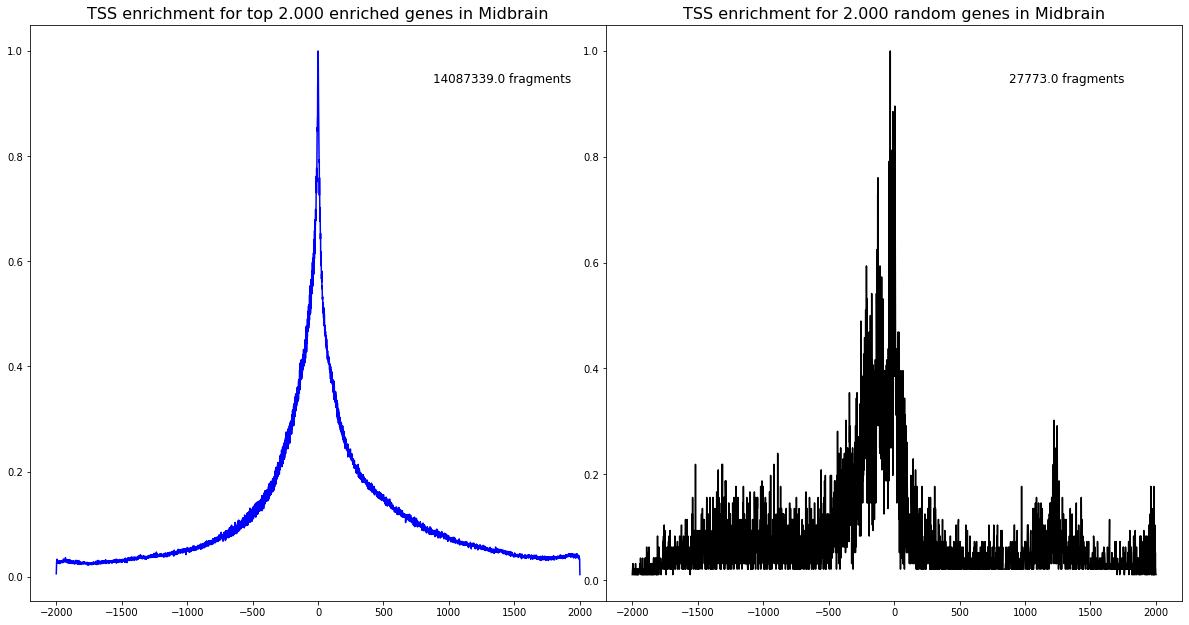

In [149]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_axes([0, 0, 0.5, 1])

ax.plot(pos['dist'], pos['fraq'], c = 'blue')
ax.set_title(f"TSS enrichment for top 2.000 enriched genes in Midbrain", {'fontsize': 16})
ax.text(0.7, 0.9, f"{sum(pos['count'])} fragments", {'fontsize': 12}, transform=ax.transAxes)

ax2 = fig.add_axes([0.5, 0, 0.5, 1])
ax2.plot(pos_bg['dist'], pos_bg['fraq'], c = 'black')
ax2.set_title(f"TSS enrichment for 2.000 random genes in Midbrain", {'fontsize': 16})
ax2.text(0.7, 0.9, f"{sum(pos_bg['count'])} fragments", {'fontsize': 12}, transform=ax2.transAxes)
fig.savefig('/home/camiel/misc/TSS_midbrain_enrichment.png', format="png", dpi=144, bbox_inches='tight')